# <p><FONT color=blue>SLIDES INPUT</FONT></p>


## <p><FONT color=blue>DATA FOR FIGURES</FONT></p>

<p><FONT color=blue>load packages</FONT></p>

In [1]:
import numpy as np
import pandas as pd

np.random.seed(123)

### <p><FONT color=blue>INTRODUCTORY PART</FONT></p>
<p><FONT color=blue>classification data</FONT></p>

In [2]:
df_cl = pd.DataFrame(np.random.rand(300,4), columns = ['x', 'y', 'e_x', 'e_y'])
df_cl.e_x = (df_cl.e_x-.5) / 5
df_cl.e_y = (df_cl.e_y-.5) / 5
df_cl['mark'] = df_cl.y > (df_cl.x+df_cl.e_x+.1)**6 + .2 +df_cl.e_y

p = 20
df_cl.x = (df_cl.x*p).round()/p
df_cl.y = (df_cl.y*p).round()/p
df_cl.drop_duplicates(['x', 'y'], inplace=True)

<p><FONT color=blue>regression data</FONT></p>

In [3]:
n = 200
df_reg = pd.DataFrame({'x':np.random.rand(n), 
                       'e':np.random.normal(size=n,scale=.01)})


df_reg['y'] = df_reg.pipe(lambda d: 3*(d.x**2-d.x) + 0.875+ # fct
                          d.e +  # error
                          np.sin(d.x * np.pi*2*5) / 10) # harmonic vibrations
                         
df_reg.x = (df_reg.x*p).round()/p
df_reg.drop_duplicates('x', inplace=True)

<p><FONT color=blue>prediction data</FONT></p>

In [4]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

In [5]:
lin_reg = LinearRegression(fit_intercept=False)
log_reg = LogisticRegression(C=10**10, fit_intercept=False)

x = np.arange(0,1,.001)
X_1d = x.reshape((1000,1))
grid = np.mgrid[0:1:.01, 0:1:.01]
xx, yy = grid
X_2d = grid.reshape(2,10000).T

# linear model
poly1 = PolynomialFeatures(degree=1,include_bias=True)
X1_1d = poly1.fit_transform(X_1d)
X1_2d = poly1.fit_transform(X_2d)
X1_reg = poly1.fit_transform(df_reg[['x']].values)
X1_class = poly1.fit_transform(df_cl[['x','y']].values)
y_pred_reg_1 = lin_reg.fit(X1_reg, df_reg.y).predict(X1_1d)
y_pred_class_1 = log_reg.fit(X1_class, df_cl.mark).predict_proba(X1_2d)[:,1]
probs_class_1 = y_pred_class_1.reshape(xx.shape)

# non-linear, balanced model
X_bal_1d = np.hstack([np.ones(X_1d.shape), X_1d, X_1d**2])
X_bal_2d = np.hstack([np.ones(X_2d[:,:1].shape), X_2d[:,:1]**6, X_2d[:,1:]])
X_bal_reg = np.hstack([np.ones((len(df_reg), 1)), df_reg[['x']].values, df_reg[['x']].values**2])
X_bal_class = np.hstack([np.ones((len(df_cl),1)), df_cl[['x']].values**6, df_cl[['y']].values])
y_pred_reg_bal = lin_reg.fit(X_bal_reg, df_reg.y).predict(X_bal_1d)
y_pred_class_bal = log_reg.fit(X_bal_class, df_cl.mark).predict_proba(X_bal_2d)[:,1]
probs_class_bal = y_pred_class_bal.reshape(xx.shape)

# non-linear, hypersensitive model
poly_high1 = PolynomialFeatures(degree=10,include_bias=True)
poly_high2 = PolynomialFeatures(degree=10,include_bias=True)
X_high_1d = poly_high1.fit_transform(X_1d)
X_high_2d = poly_high2.fit_transform(X_2d)
X_high_reg = poly_high1.fit_transform(df_reg[['x']].values)
X_high_class = poly_high2.fit_transform(df_cl[['x','y']].values)
y_pred_reg_high = lin_reg.fit(X_high_reg, df_reg.y).predict(X_high_1d)
y_pred_class_high = log_reg.fit(X_high_class, df_cl.mark).predict_proba(X_high_2d)[:,1]
probs_class_high = y_pred_class_high.reshape(xx.shape)

C:\Users\bvq720\AppData\Local\Continuum\Miniconda3\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


### <p><FONT color=blue>REGULARIZATION PART</FONT></p>

In [6]:
def my_fct(x): 
    return 2+8*x**4

np.random.seed(1234)

n_p = 50
X_p = np.arange(0, 1, 1/n_p).reshape((n_p,1))
errors =  np.random.normal(size=(n_p))
y_p = my_fct(X_p[:,0]) + errors



In [7]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  KFold, ShuffleSplit

lin_reg = LinearRegression(fit_intercept=False)
lasso = Lasso(alpha=.02)
kf = KFold(n_splits=10)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

errors = []



def apply_compute_rmse(reg, y, X, train_index, test_index, output = 'rmse', sample='test'):
    reg_fit = reg.fit(X[train_idxs], y_p[train_idxs])  
    
    if output == 'rmse':
        if sample=='test':
            y_pred = reg_fit.predict(X[test_idxs])
            return root_mean_squared_error(y_pred, y_p[test_idxs])
        else:
            y_pred = reg_fit.predict(X[train_idxs])
            return root_mean_squared_error(y_pred, y_p[train_idxs])
    elif output == 'coef':
        return reg_fit.coef_
    else:
        raise ValueError
        
    
    
error_train, error_test = [],[]
error_train_lasso, error_test_lasso = [],[]
coef, coef_lasso = [], []


splits = list(kf.split(y_p))

train_idxs, test_idxs = next(ShuffleSplit(n_splits=1, test_size=.5, random_state=45).split(y_p))

for n in range(10):
    X_p_n = PolynomialFeatures(degree=n, include_bias=True).fit_transform(X_p)
    
    error_in, error_out = [], []
    error_out_lasso, error_in_lasso = [], []
    
    model_input = y_p, X_p_n, train_idxs, test_idxs
    
    coef += [apply_compute_rmse(lin_reg, *model_input, output='coef',sample='train')]
    coef_lasso += [apply_compute_rmse(lasso, *model_input, output='coef',sample='train')]
    error_test.append(apply_compute_rmse(lin_reg, *model_input))
    error_train.append(apply_compute_rmse(lasso, *model_input))
    error_test_lasso.append(apply_compute_rmse(lin_reg, *model_input, sample='train'))
    error_train_lasso.append(apply_compute_rmse(lasso, *model_input, sample='train'))
    
#     # cross validated version        
#     for i, (train_idxs, test_idxs) in enumerate(splits):
#         model_input = y_p, X_p_n, train_idxs, test_idxs
#         error_out += [apply_compute_rmse(lin_reg, *model_input)]
#         if i == 0:
#             print(error_out[0])

#         error_out_lasso += [apply_compute_rmse(lasso, *model_input)]
#         error_in += [apply_compute_rmse(lin_reg, *model_input, sample='train')]
#         error_in_lasso += [apply_compute_rmse(lasso, *model_input, sample='train')]
        
#     error_test.append(np.mean(error_out))
#     error_train.append(np.mean(error_in))
#     error_test_lasso.append(np.mean(error_out_lasso))
#     error_train_lasso.append(np.mean(error_in_lasso))
    

In [8]:
coef_tables = {}

for label, coef_tab in ('lin_reg', coef), ('lasso', coef_lasso):

    coef_table  = \
        pd.concat(dict([(i+1,pd.Series(a)) for i,a in enumerate(coef_tab[:6])]),1)\
            .T\
            .applymap(lambda v: '%.1f' % v if not np.isnan(v) else '')
    coef_table.index = pd.MultiIndex.from_product([['Num. coeff.'], coef_table.index])
    coef_table.columns = pd.MultiIndex.from_product([['Polynomial order'], coef_table.columns])

    coef_tables[label] = coef_table

## <p><FONT color=blue>MAKING FIGURES</FONT></p>

In [9]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

colors = sns.color_palette("Set1", 3)

def plot_points(ax, title, dtype):
    if dtype=='classification':
        df_cl[df_cl.mark].plot.scatter('x', 'y', color=sns.color_palette()[0],ax=ax)
        df_cl[~df_cl.mark].plot.scatter('x', 'y', color=sns.color_palette()[1],ax=ax)
        ax.set_ylim(-0.05,1.05)
    elif dtype=='regression':
        df_reg.plot.scatter('x','y', ax=ax)    
    else:
        raise ValueError
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    
    
    
model_label = 'estimated model'
dgp_label = 'data generating process'
def plot_line(ax, dtype, ltype):
    if dtype=='classification':
        if ltype == 'true':
            return ax.plot(x[x<.865], (x[x<.865]+.1)**6 + .2, color=sns.color_palette()[2], label=dgp_label)[0]
        elif ltype in ['balanced', 'underfit', 'overfit']:
            if ltype == 'balanced':
                probs_in = probs_class_bal
            elif ltype == 'underfit':
                probs_in = probs_class_1
            elif ltype == 'overfit':      
                probs_in = probs_class_high
            CS = ax.contour(xx, yy, probs_in, levels=[.5], cmap="Greys", vmin=0, vmax=.6)                         
            CS.collections[0].set_label(model_label)
            return CS.collections[0]
        else:
            raise ValueError
        
        
    elif dtype=='regression':
        if ltype == 'true':
            return ax.plot(x, 3*(x**2-x) + 0.875, color=sns.color_palette()[2], label=dgp_label)[0]
        elif ltype == 'balanced':
            return ax.plot(x, y_pred_reg_bal, color='black', label=model_label)[0]
        elif ltype == 'underfit':
            return ax.plot(x, y_pred_reg_1, color='black', label=model_label)[0]
        elif ltype == 'overfit':
            return ax.plot(x, y_pred_reg_high, color='black', label=model_label)[0]
        else:
            raise ValueError
        
    else:
        raise ValueError    
        
        
font = {'size'   : 18}

mpl.rc('font', **font)

fig_factor = 1.5
figsize1 = np.array((8,5))*fig_factor
figsize2 = np.array((11,5))*fig_factor
figsize3 = np.array((11,5/3*2))*fig_factor        

<p><FONT color=blue>model complexity</FONT></p>

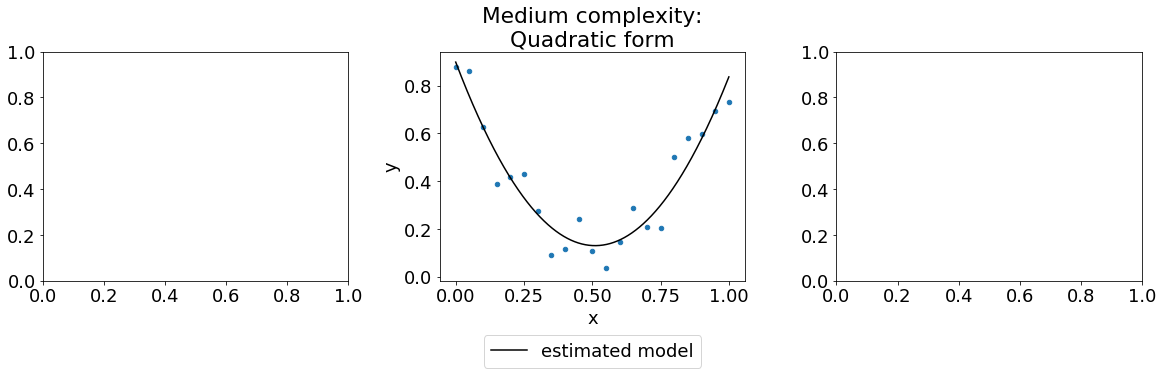

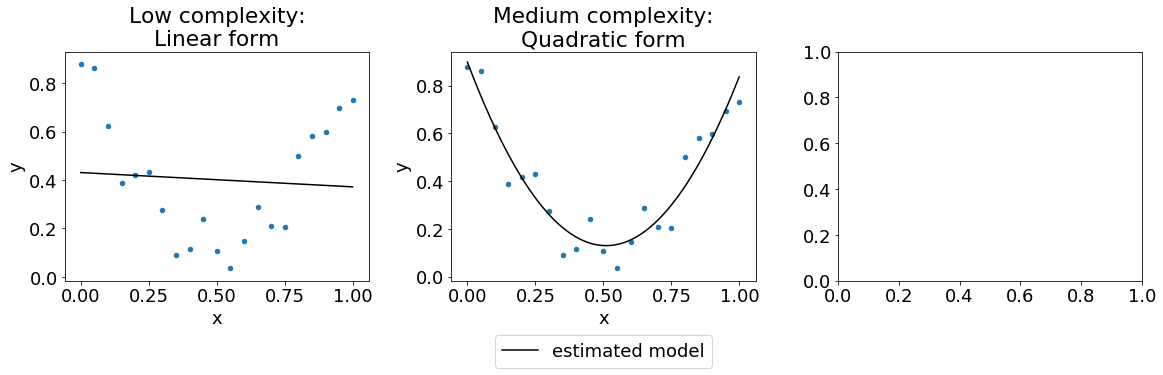

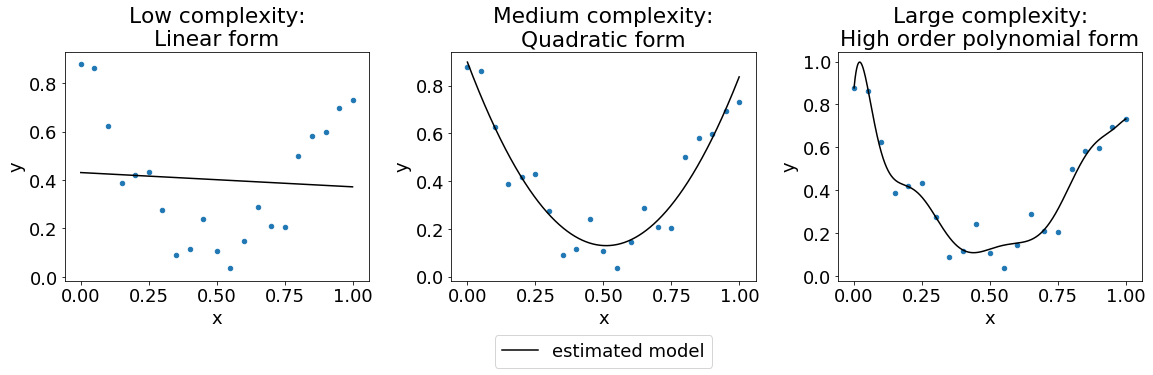

In [10]:
f_complexity = [None]*3

estimate_type = 'regression'

for iteration in range(3):

    f_complexity[iteration], ax = plt.subplots(1,3, figsize = figsize3)

    plot_points(ax[1], 'Medium complexity:\nQuadratic form', estimate_type)
    model = plot_line(ax[1], estimate_type, 'balanced')
    
    ax[1].legend(handles=[model], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

    
    if iteration > 0:        
        plot_points(ax[0], 'Low complexity:\nLinear form', estimate_type)
        plot_line(ax[0], estimate_type, 'underfit')


    if iteration > 1:
        plot_points(ax[2], 'Large complexity:\nHigh order polynomial form', estimate_type)
        plot_line(ax[2], estimate_type, 'overfit')
        
    plt.tight_layout()

<p><FONT color=blue>student identify methods: question</FONT></p>

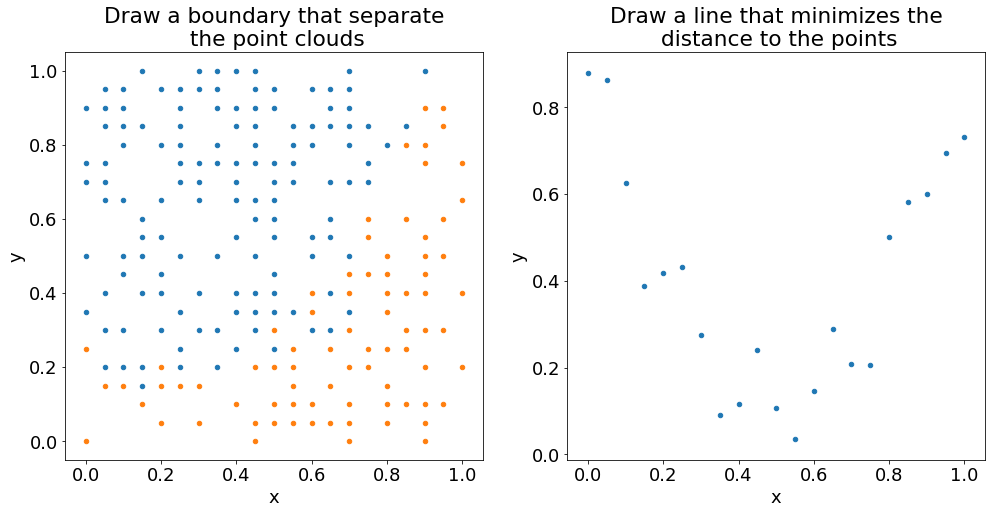

In [11]:
f_identify_question, ax = plt.subplots(1,2, figsize = figsize2)

plot_points(ax[0], 'Draw a boundary that separate\n the point clouds', 'classification')
plot_points(ax[1], 'Draw a line that minimizes the\n distance to the points', 'regression')

<p><FONT color=blue>student identify methods: answer</FONT></p>

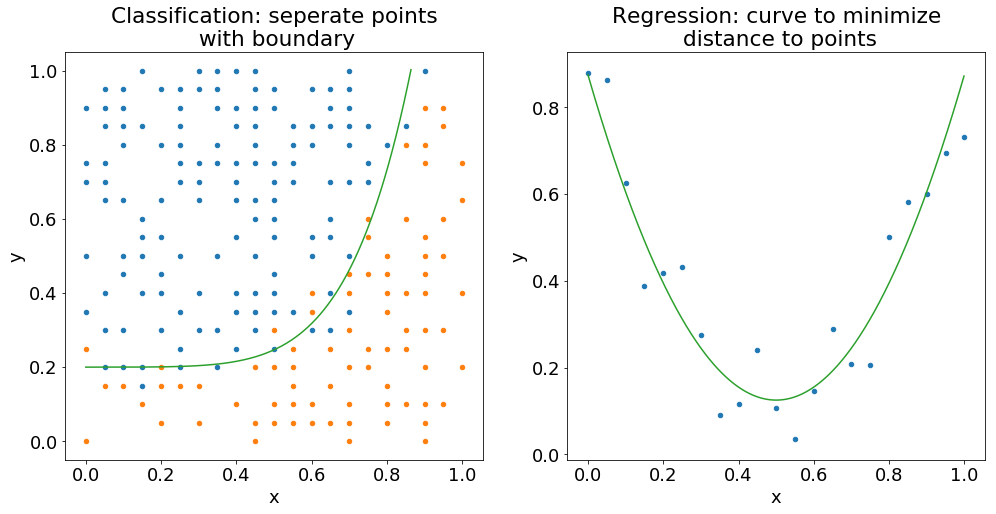

In [12]:
f_identify_answer, ax = plt.subplots(1,2, figsize = figsize2)    
plot_points(ax[0], 'Classification: seperate points\n with boundary', 'classification')
plot_points(ax[1], 'Regression: curve to minimize\n distance to points', 'regression')
plot_line(ax[0], 'classification', 'true')
plot_line(ax[1], 'regression', 'true')

<p><FONT color=blue>bias variance tradeoff - multiple figures </FONT></p> 

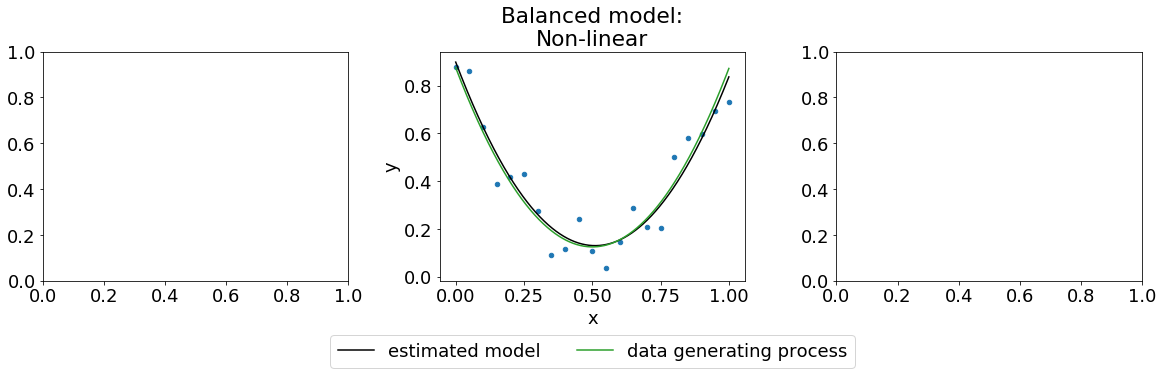

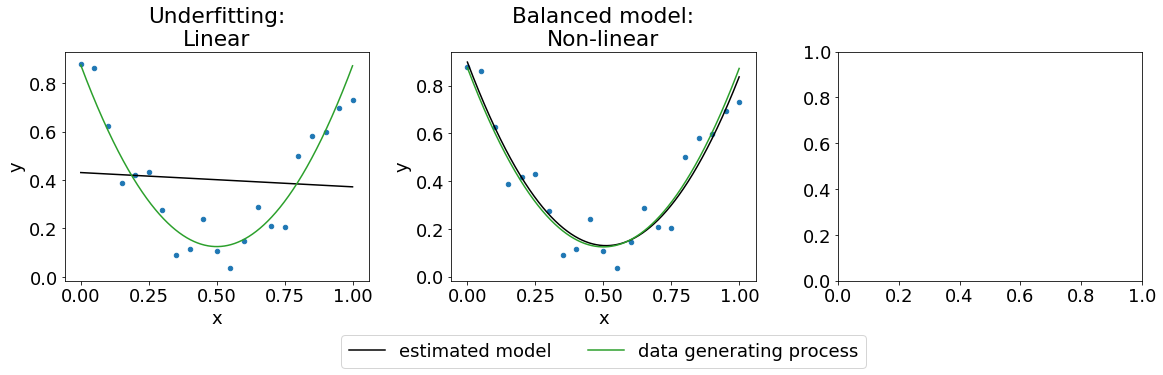

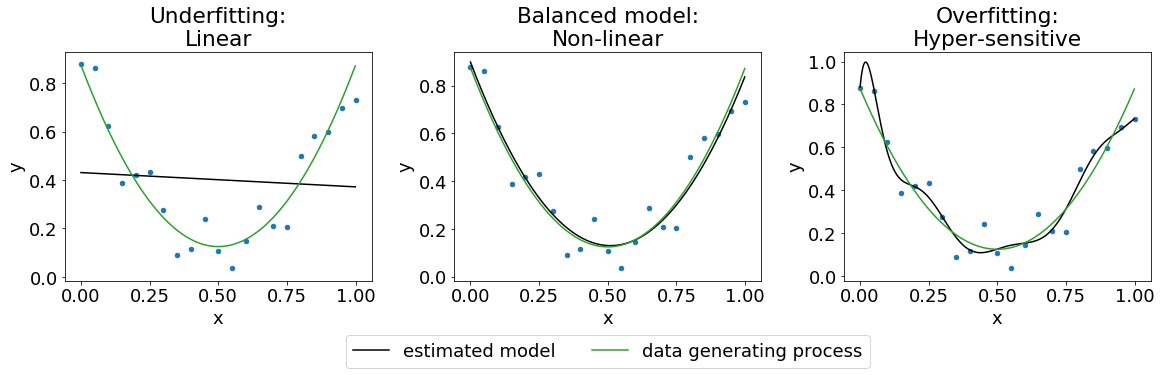

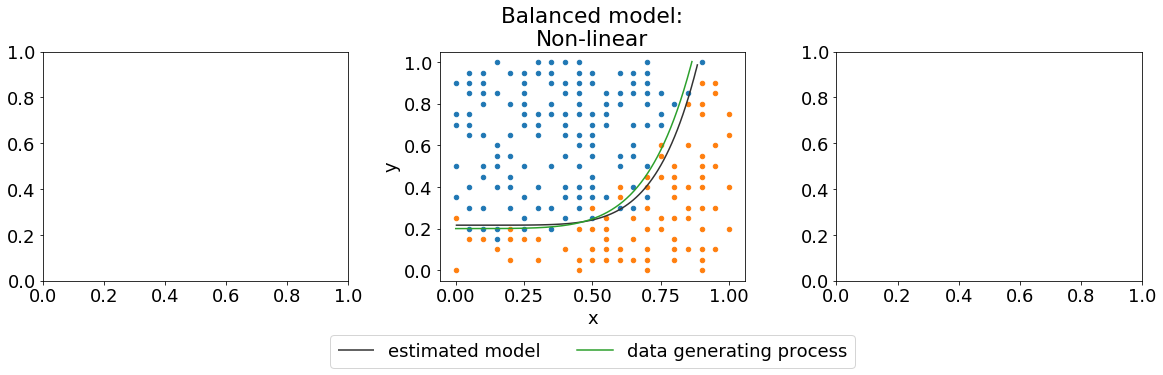

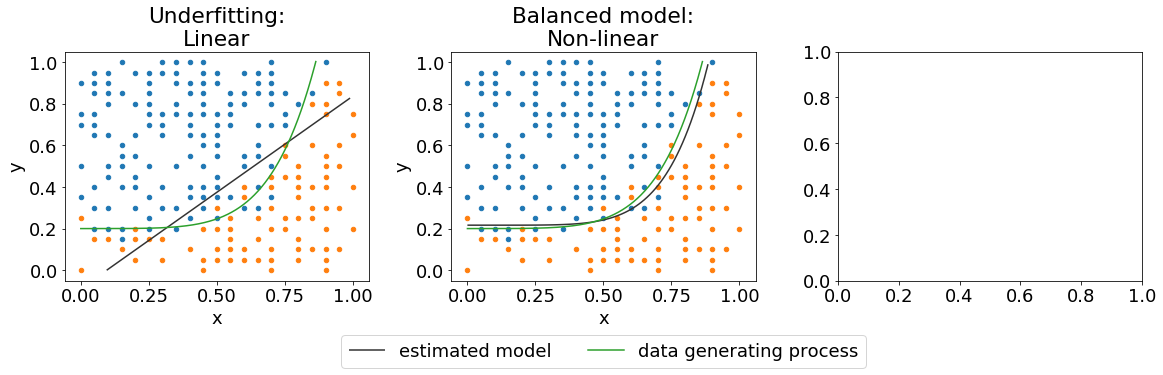

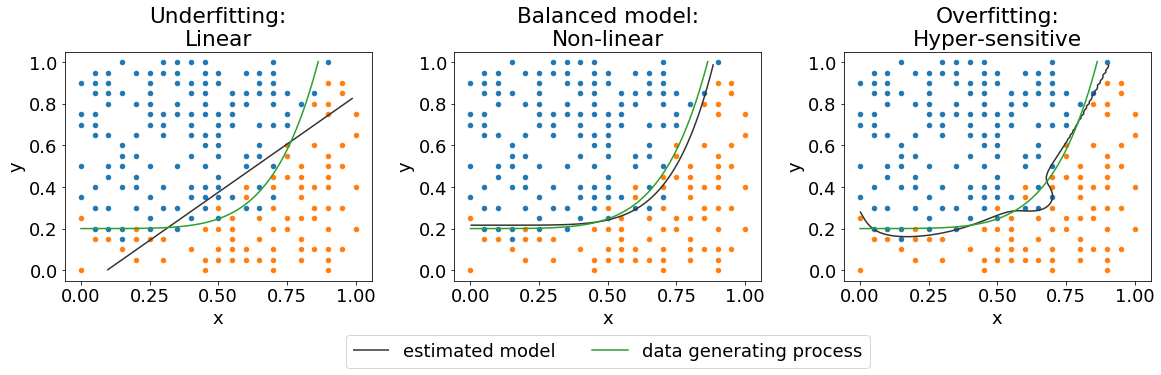

In [13]:
f_bias_var = {}

for estimate_type in 'regression', 'classification':
    f_bias_var[estimate_type] = [None]*3

    for iteration in range(3):

        f_bias_var[estimate_type][iteration], ax = plt.subplots(1,3, figsize = figsize3)

        plot_points(ax[1], 'Balanced model:\nNon-linear', estimate_type)
        model = plot_line(ax[1], estimate_type, 'balanced')
        dgp = plot_line(ax[1], estimate_type, 'true')
        
        ax[1].legend(handles=[model, dgp], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
        
        
        if iteration > 0:        
            plot_points(ax[0], 'Underfitting:\nLinear', estimate_type)
            plot_line(ax[0], estimate_type, 'underfit')
            plot_line(ax[0], estimate_type, 'true')


        if iteration > 1:
            plot_points(ax[2], 'Overfitting:\nHyper-sensitive', estimate_type)
            plot_line(ax[2], estimate_type, 'overfit')
            plot_line(ax[2], estimate_type, 'true')
        
        
        plt.tight_layout()

### <p><FONT color=blue>polynomial</FONT></p> 

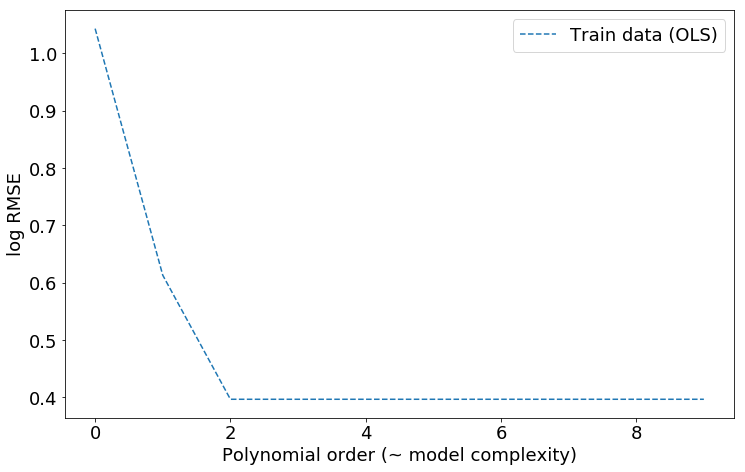

In [36]:
f_poly_within, ax = plt.subplots(figsize=figsize1)

ax.plot(np.log(error_train), '--', label='Train data (OLS)', color = sns.color_palette()[0])
ax.legend()
ax.set_xlabel('Polynomial order (~ model complexity)')
ax.set_ylabel('log RMSE')


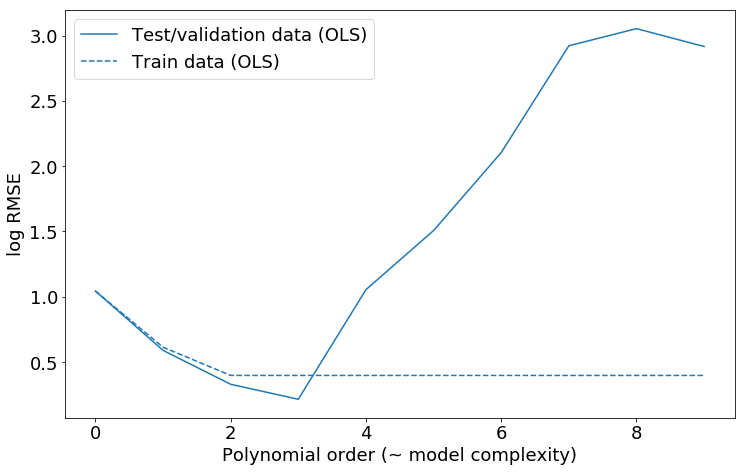

In [32]:
f_poly, ax = plt.subplots(figsize=figsize1)

ax.plot(np.log(error_test), label='Test/validation data (OLS)', color = sns.color_palette()[0])
ax.plot(np.log(error_train), '--', label='Train data (OLS)', color = sns.color_palette()[0])
ax.legend()
ax.set_xlabel('Polynomial order (~ model complexity)')
ax.set_ylabel('log RMSE')


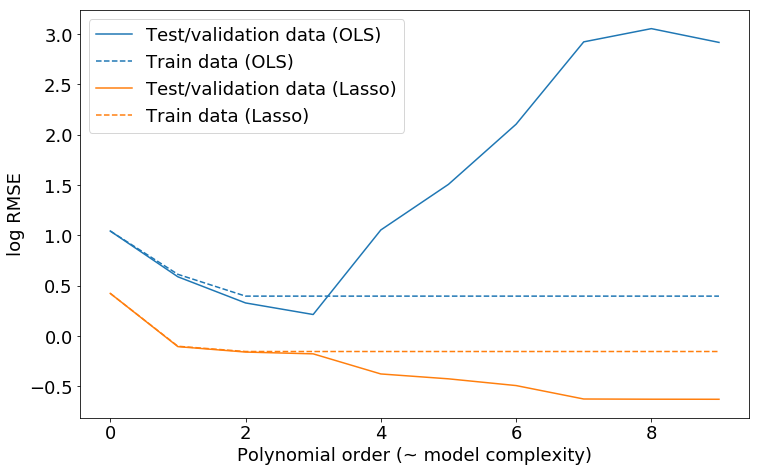

In [33]:
f_poly_lasso, ax = plt.subplots(figsize=figsize1)

ax.plot(np.log(error_test), label='Test/validation data (OLS)', color = sns.color_palette()[0])
ax.plot(np.log(error_train), '--', label='Train data (OLS)', color = sns.color_palette()[0])
ax.plot(np.log(error_test_lasso), label='Test/validation data (Lasso)', color = sns.color_palette()[1])
ax.plot(np.log(error_train_lasso), '--', label='Train data (Lasso)', color = sns.color_palette()[1])
ax.legend()

ax.set_xlabel('Polynomial order (~ model complexity)')
ax.set_ylabel('log RMSE')

# Data modelling 
*Andreas Bjerre-Nielsen*

## Overview of today

* data modelling
* supervised machine learning
    * problem types
    * bias-variance tradeoff
    * model validation
* unsupervised machine learning


## Introduction (1)

What is the objective of data modelling? 


1. establish empirical patterns:

    - *correlation*: what is the interplay between A and B?
    
    - *causation*: how does A effect B?
    
2. optimize function:

    - *prediction*: find some function that provides a good prediction of $y$ as a function of $x$
    
    - *decision-making/AI*: find some function that takes optimal decision $y$ given $x$

## Introduction (2)

Assume a model of the form:

$$ y = \alpha + \beta x + \varepsilon $$


The agendas are:

- *causation/correlation*: interested in $\hat{\beta}$ 

- *prediction/AI*: interested in minimizing 'error', e.g. $f(\hat{y}-y)$ 


## Data models - complexity

Let the model be a $p$-order polynomial

$$ y = \sum_{k=0}^{p}(\beta_k x^k) + \varepsilon $$

- model is 1-dimensional
- model complexity increases with $p$

## Data models - complexity (2)

What does complexity look like in this model:

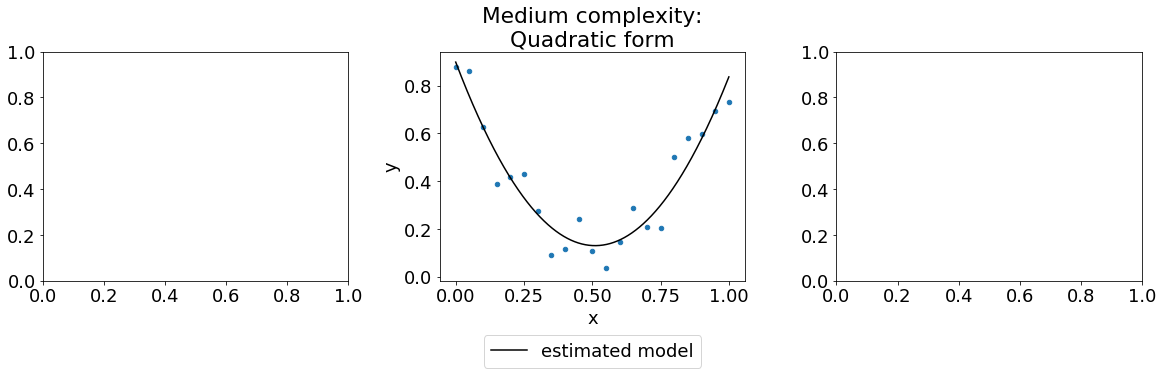

In [16]:
f_complexity[0]

## Data models - complexity (3)

What does complexity look like in this model:

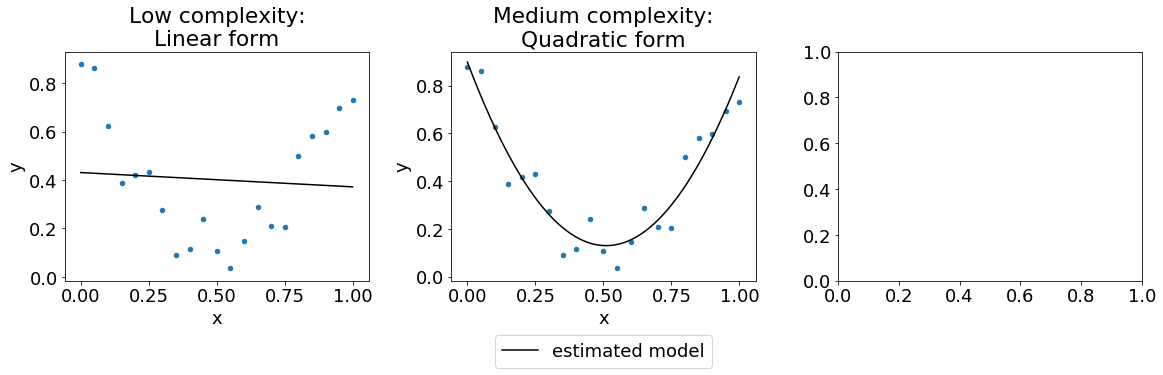

In [17]:
f_complexity[1]

## Data models - complexity (4)

What does complexity look like in this model:

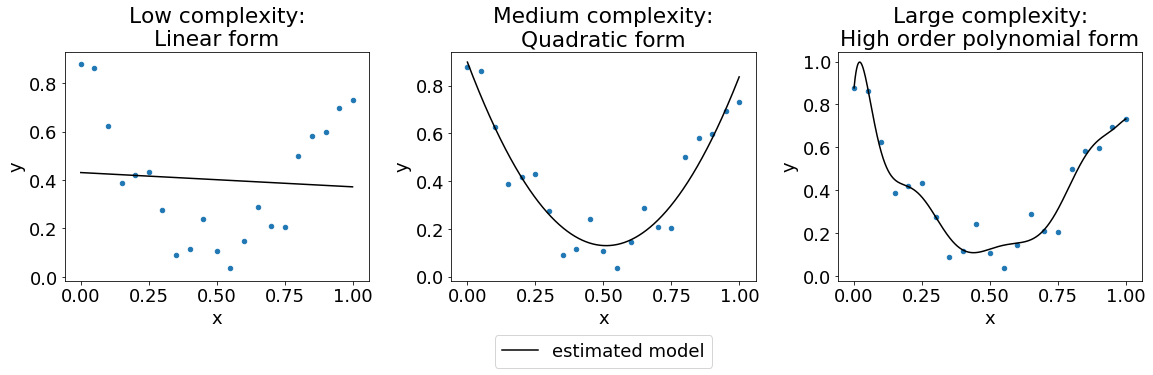

In [18]:
f_complexity[2]

# Machine learning 


## Machine learning concepts (1)


What is labeled data?


- Outcomes that can be modeled, e.g. be predicted


- Examples: 
    - whether a friendship exist between two people
    - how long a person lives or how much he/she earns 
    - future house prices, stock prices, economic growth
    - a person's gender, political attitudes etc.

## Machine learning concepts (2)


*Supervised Learning*: 
- Models designed to infer a relationship between input and **labeled** training data. 
- These models are used for **prediction** but also **'post-diction'**. 
- Terminology in supervised problem $y=\beta X+\epsilon$
    - variable $y$ is called **label** (~ outcome / endogenous) 
    - variables in $X$ are called **features** (~ explanatory / exogenous) 



*Unsupervised Learning*:  
- Models designed to infer a relationship from **unlabeled** training data. 
- This may involve clustering, dimensionality reduction and more.

## Machine learning concepts (3)

Supervised learning is divided into two sub-problems according to the data type of the labelled variable:
- The first is **regression** which models continuous numeric variables.
- The second is **classification**  which models categorical (discrete) variables.

## Machine learning concepts (4)

Which of the problems below correspond to respectively regression and classification?

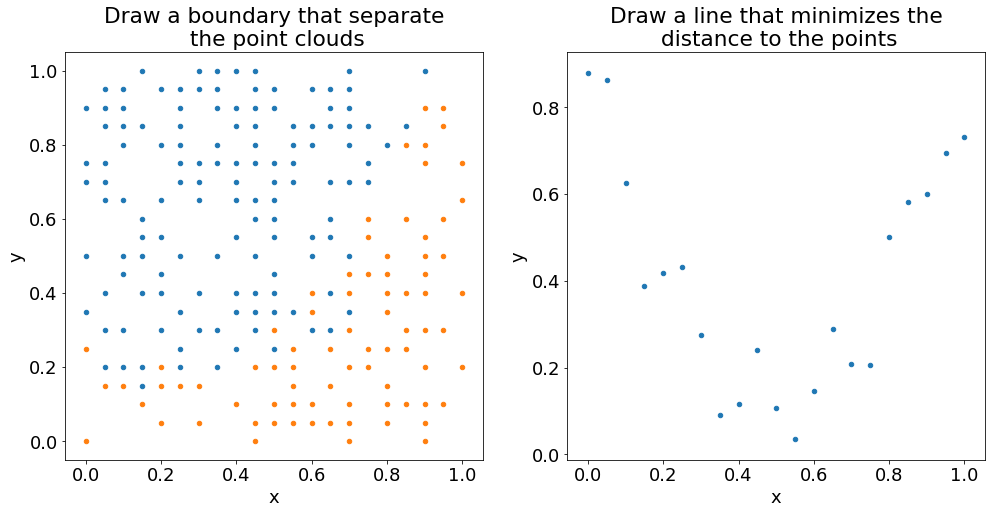

In [19]:
f_identify_question

## Machine learning concepts (5)

The solutions

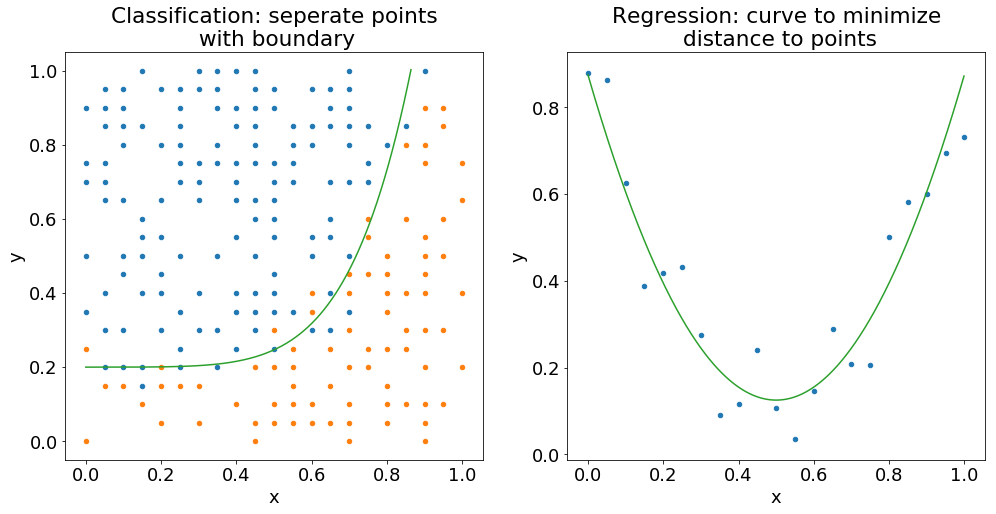

In [20]:
f_identify_answer

## Machine learning concepts (6)

Some familiar models we already know

- Regression: linear regression
- Classification: logistic regression

# Model evaluation 

## The fundamental problem

The goal of supervised machine learning is to make models that minimize the error.

How do we do that?

## The fundamental problem (2)

Evaluating a model's error on the same data where you estimate the model is dangerous:
- in OLS adding more variables always decrease error 
- patterns may not generalize to another sample (overfitting) 

We can handle overfitting by measuring performance on another set of observations

## The fundamental problem (3)

### You're damned if you do and you're damned if you don't 

We are faced with trading off two undesirable properties
- ***underfitting***, i.e. not finding all the available patterns which are avaialble from the data (**=bias**)
    - problem *decreases* with model complexity
- ***overfitting***, i.e. finding spurious patterns that are not generalizable in other datasets (**=variance**)
    - problem *increases* with model complexity
    
This problem is known as the **bias-variance tradeoff**.

## The fundamental problem (4)

### How and why we measure it: splitting data

Make a random split of data into:
- Development set; this has two sub-components (~ in-sample)
    - training data where we estimate our model 
    - validation data where we evaluate the assumptions we make (optional)
- Test data: where we evaluate the model's accuracy (~ out-of-sample)



## The fundamental problem (5)

### How and why we measure it: splitting data

Validation and test are not used for estimation. 
- Can be used to evaluate overfitting!

Difference between train and validation indicates
- Underfitting – if both validation and training error are high    
- Overfitting – if validation error is high, training error low
- Good fit, i.e. balanced – if validation error low, slightly higher than the training error

## Bias-variance tradeoff - classification (1)

We can get an idea of how over-fitting, under-fitting may appear in a classification model. This is possible by comparison with the underlying data generating process.

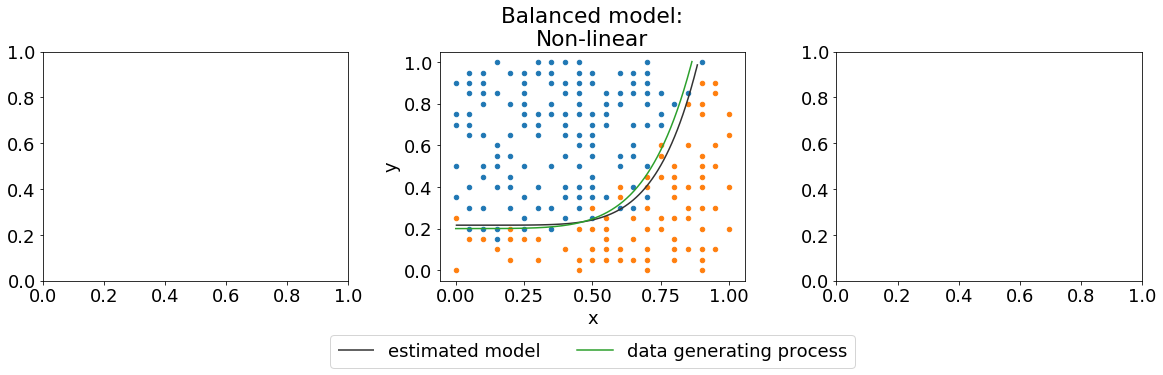

In [21]:
f_bias_var['classification'][0]

## Bias-variance tradeoff - classification (2)

We can get an idea of how over-fitting, under-fitting may appear in a classification model. This is possible by comparison with the underlying data generating process.

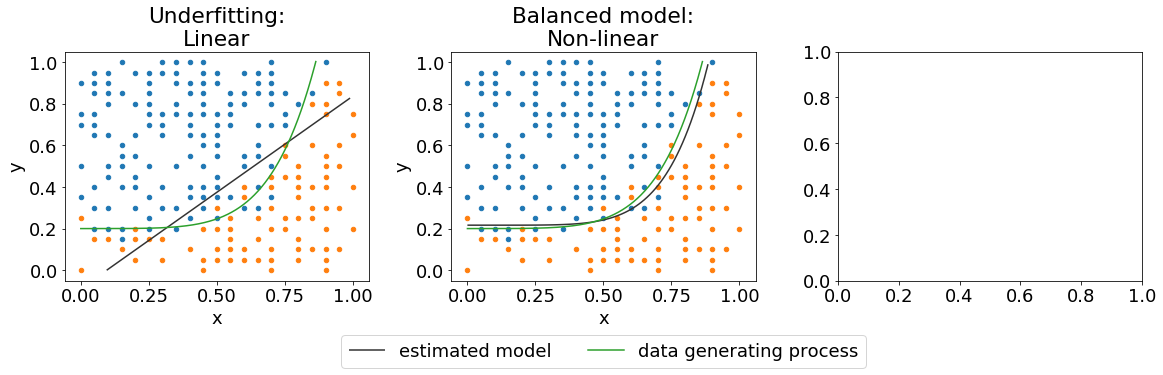

In [22]:
f_bias_var['classification'][1]

## Bias-variance tradeoff - classification (3)

We can get an idea of how over-fitting, under-fitting may appear in a classification model. This is possible by comparison with the underlying data generating process.

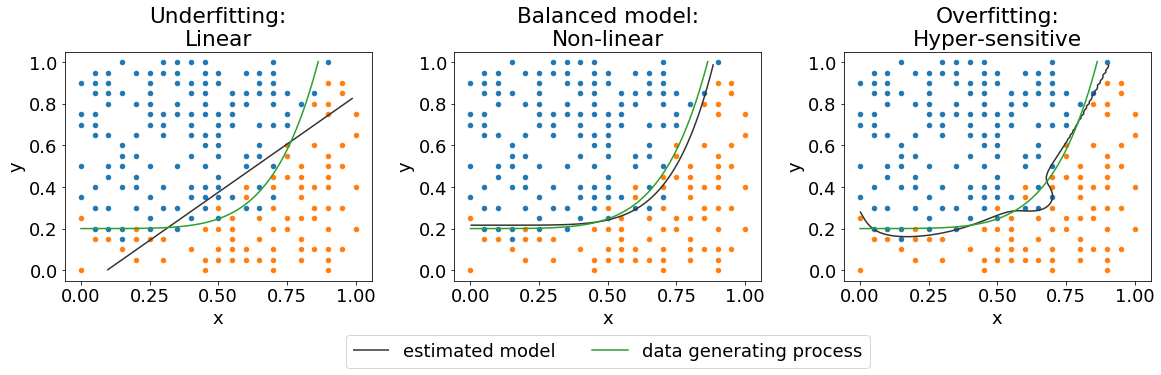

In [23]:
f_bias_var['classification'][2]

## Bias-variance tradeoff - regression (1)

### Visualization

We can get an idea of how over-fitting, under-fitting may appear in a regression model. This is possible by comparison with the underlying data generating process.

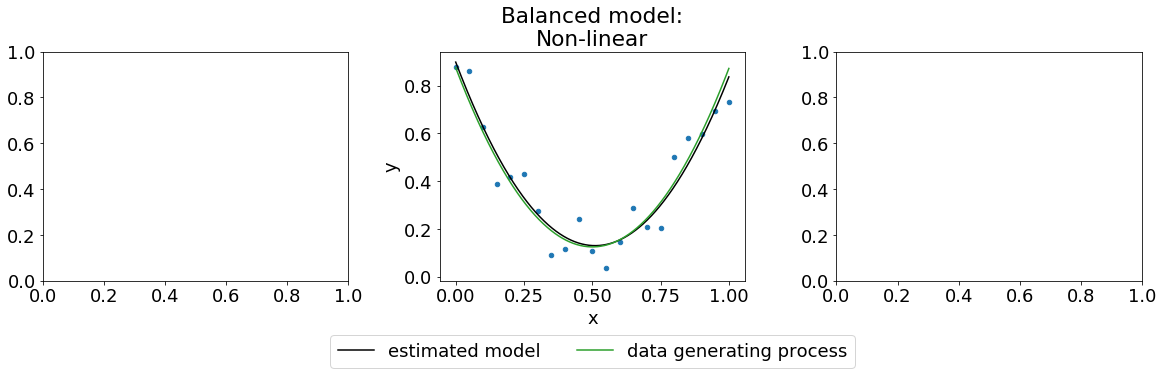

In [24]:
f_bias_var['regression'][0]

## Bias-variance tradeoff - regression (2)

### Visualization

We can get an idea of how over-fitting, under-fitting may appear in a regression model. This is possible by comparison with the underlying data generating process.

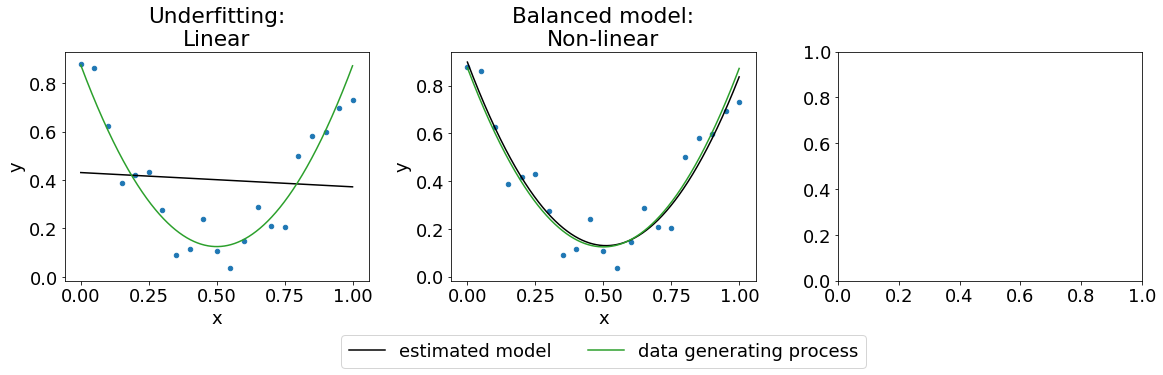

In [25]:
f_bias_var['regression'][1]

## Bias-variance tradeoff - regression (3)

### Visualization

We can get an idea of how over-fitting, under-fitting may appear in a regression model. This is possible by comparison with the underlying data generating process.

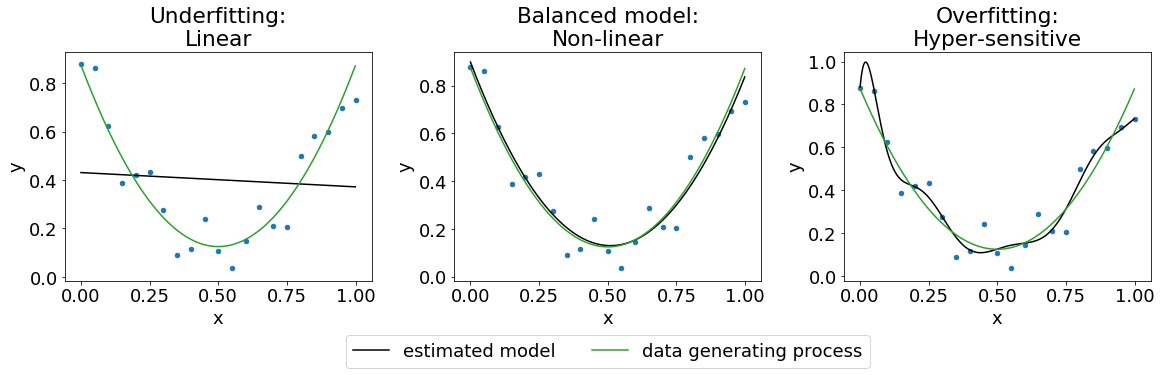

In [26]:
f_bias_var['regression'][2]

## Bias-variance tradeoff - regression (4)

### Error measures for regression

How do we measure error for regressions? 

**Mean absolute error (MAE)**:

$$MAE = \frac{1}{n} \sum_{i=1}^{n} |\hat{y}_i - y_i|$$

**Mean squared error (MSE)**:

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2$$


## Bias-variance tradeoff - regression (5)

OLS is designed to minimize *in sample error*: the error rate you get on the same data set you used to build your predictor.

$$ \text{arg min}_{\beta} \underset{=MSE}{\underbrace{\sum_{i = 1}^{n}(y_i - \hat{y}_i)^2}}   = \text{arg min}_{\beta} (\underset{Var(\hat{f}(x))}{\underbrace{\mathbb{E}[\hat{f}(x_0)^2]-\mathbb{E}[\hat{f}(x_0)]^2}} + \sigma^2) $$

But goal of supervised learning:
- minimizing *out of sample error*: the error rate you get on a new data set


## Bias-variance tradeoff - regression (6)

Consider a prediction at a new point (out-of-sample), $x_0$. Our prediction for $y_0$ is then $\hat{f}(x_0)$ and the mean squared error (MSE ) can be decomposed as 

$$ \mathbb{E}[(y_0 - \hat{f}(x_0))^2] = 
\underset{Bias(\hat{f}(x))}{\underbrace{\mathbb{E}[\hat{f}(x_0)-f(x_0)]}}^2 + 
\underset{Var(\hat{f}(x))}{\underbrace{\mathbb{E}[\hat{f}(x_0)^2]-\mathbb{E}[\hat{f}(x_0)]^2}} +
\sigma^2$$

By ensuring zero bias within sample, OLS picks a solution which will not be optimal for prediction 
- in many cases we can lower variance while increasing bias a little. 

## Bias-variance tradeoff - regression (7)

What do we mean by the *variance* and *bias* of an estimator?

- *Bias*: Comes from using erroneous model assumptions, e.g. fitting non-linear fct. $f$ with linear fct. $\hat{f}$. 
    - Can lead to missing relevant patterns in data, i.e. *underfitting*.

- *Variance*: Refers to model complexity. If the model is too complex then small changes to the data will cause the solution to change a lot. 
    - Can lead to finding spurious patterns in data, i.e. *overfitting*.

Machine learning techniques were developed specifically to maximize prediction performance by providing an empirical way to make this bias-variance trade off

## Bias-variance tradeoff - regression (8)

*So why do we care about zero bias?*

- By not modelling bias: allows *inference*, i.e. testing hypotheses! (model parameters converge to true parameters) ~ interested in $\hat{\beta}$
    
- By modelling bias: allows better predictive models as they trade off bias and variance. Interested in $\hat{y}$

# Supervised regression models

## Fitting a polynomial
Polyonomial: $f(x) = 2+8*x^4$

Try models of increasing order polynomials. Procedure:
- Split data into train and test (50/50)
- Evaluate order polynomial order 0 to 9:
    - Iteration n: $y = \sum_{k=0}^{n}(\beta_k\cdot x^k)+\varepsilon$.
    - Estimate order n model on training data
    - Evaluate with on test data with RMSE: 
        - $log RMSE = \log (\sqrt{MSE})$     

## Fitting polynomial (2)

*Compute sample errors for OLS - test and training*


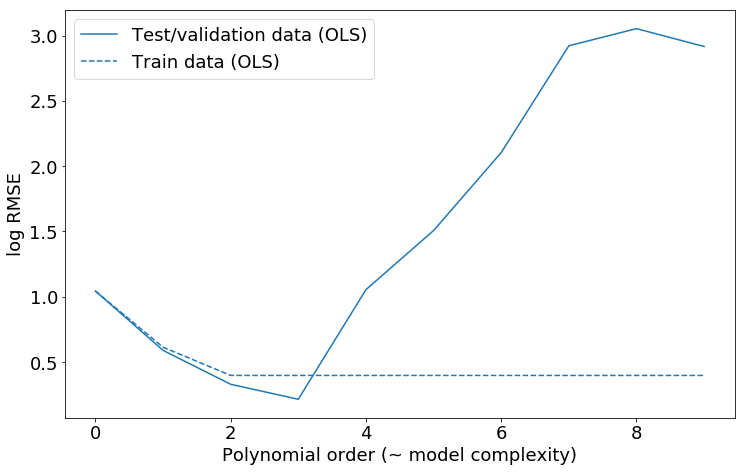

In [35]:
f_poly

## Fitting polynomial (3)

Drivers of overfitting 
- more and more spurious relations are included
- divergence of estimates - coefficient explode as complexity grows!!


In [28]:
print(coef_tables['lin_reg'])

              Polynomial order                                      
                             0     1       2       3       4       5
Num. coeff. 1              3.3                                      
            2              1.1   4.8                                
            3              1.8   0.2     5.2                        
            4              1.4   5.9   -10.7    12.0                
            5             -0.3  41.5  -193.0   332.4  -180.7        
            6              0.6  14.0    20.5  -307.7   634.3  -370.0


## Regularization

*We have a problem with overfitting, how do we solve it?*

- One solution to avoid overfitting and have better predictions is to **regularize**

*How do we regularize?*


- We make models which are less complex by reducing the number and/or size of the coefficients.

## Regularization (2)

*What does regularization look like?*

We add a penalty term our optimization procedure:
    
$$ \text{arg min}_\beta \, \underset{\text{MSE}}{\underbrace{\sum_i^n(y_i - \hat{y}_i)^2}} + \underset{\text{penalty}}{\underbrace{\lambda \cdot R(\beta)}}$$

Introduction of penalties implies that increased model complexity has to be met with high increases precision of estimates.

## Regularization (3)

*What are some used penalty functions?*


- L1 regularization (***Lasso***): $R(\beta)=\sum_{j=1}^{p}|\beta_j|$ 
    - Makes coefficients sparse, i.e. selects variables by removing some (if $\lambda$ is high enough)
    
   

- L2 regularization (***Ridge***): $R(\beta)=\sum_{j=1}^{p}\beta_j^2$
    - Reduce coefficient size
    
*To note:* The *Elastic Net* uses a combination of L1 and L2 regularization.

## Regularization (4)

*How the Lasso (L1 reg.) deviates from OLS*

<img src='http://rasbt.github.io/mlxtend/user_guide/general_concepts/regularization-linear_files/l1.png'>

## Regularization (5)

*How the Ridge regression (L2 reg.) deviates from OLS*

<img src='http://rasbt.github.io/mlxtend/user_guide/general_concepts/regularization-linear_files/l2.png'>

## Fitting polynomial (4)

*Comparison of OLS and Lasso*


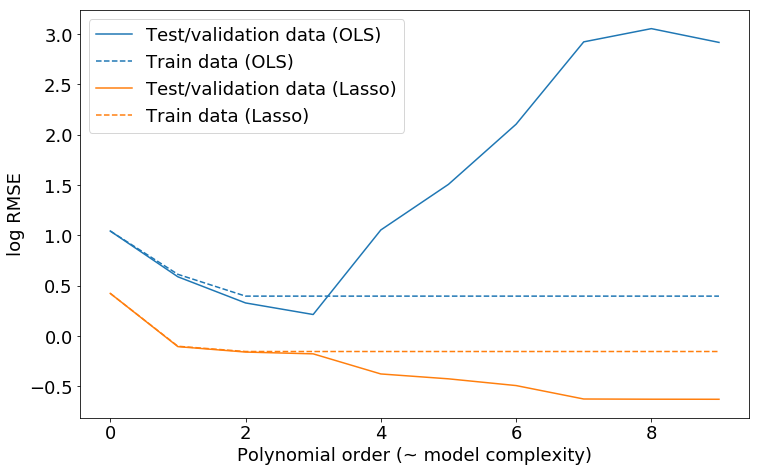

In [38]:
f_poly_lasso

## Fitting polynomial (5)

How does the Lasso solve overfitting?
- number of spurious relations does ***not*** grow
- estimates do ***not*** diverge

In [30]:
print(coef_tables['lasso'])

              Polynomial order                         
                             0    1    2    3    4    5
Num. coeff. 1              0.0                         
            2              0.0  4.5                    
            3              0.0  0.6  4.4               
            4              0.0  0.6  4.4  0.0          
            5              0.0  0.6  4.4  0.0  0.0     
            6              0.0  0.6  4.4  0.0  0.0  0.0


## Summary supervised learning

*Labelled data*: Data used to evaluate

*Supervised problems*: 
- when the response is numeric (continuous) the problem is called *regression*
- when response is categorical (discrete) the problem is called *classification*

*Bias-variance tradeoff*: There exist models beside OLS which can improve better at out-of-sample predictions, however, they have biased parameter estimates.


*MAE/RMSE*: measures of prediction accuracy for regression problems

*Model validation*: Split data in test and training data. Train model on training data, test it on test data.

*Regularization*: A technique used to model bias in an attempt to solve overfitting problems

## Summary supervised learning (2)
*Parametric models*
- regression models 
    - unbiased: OLS 
    - biased: ***Lasso*** (L1), ***Ridge*** (L2) - (regulariation)
- classifier
    - unbiased: binary and multinomial logistic, probit etc.
    - biased: logisitic regression can also be regulararized
   

## Machine learning later in course

*More concepts*
- **cross-validation**
- **model tuning** and **feature selection**
- mixing models: **ensemble learning**
- using machine learning in econometrics ~ hybrid approach

*More models*
- **regression tree** and **random forest**
- **nearest neighbor**
- specific models for text data
- **neural networks/ deep learning** (not guaranteed)